In [1]:
library(ggplot2)
library(stats)
library(dplyr)
library(tidyverse)
library(rstatix)
library(ggpubr)
library(parallel)
library(metap)

Warning message:
“package ‘dplyr’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘tidyverse’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘readr’ was built under R version 4.3.3”
Warning message:
“package ‘purrr’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘forcats’ was built under R version 4.3.3”
Warning message:
“package ‘lubridate’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     

In [2]:
meta_data<-read.csv("/home//workspace/IHA_Review_Analysis/Other_Analysis/13_MSD_HAI_analysis/meta_data.csv")
meta_data_subset <- meta_data %>%
    filter(Visit_Type == "FluYear", Flu_Year %in% c("2020-2021", "2021-2022"), Flu_Day != "Stand-Alone") %>%
    group_by(subjectGuid, Flu_Year) %>%
    mutate(entry_count = n()) %>%
    filter(entry_count == 3) %>%

    ungroup()

In [3]:
response_group<-read.csv('lm_res.csv')

In [4]:
unique(response_group$Assay )

[1] "A/Guangdong"         "Flu B/Phuket HA"     "Flu B/Washington HA"
[4] "A/Cambodia"

In [5]:
Olink<-read.csv('/home//workspace/private/bri_figure_all_files_test/jupyter/BRI_Figures_Final_V2/Figure1/01_Olink_Analysis/Olink_BRI.csv')

In [6]:
Olink_subset<-Olink %>% filter(sample.sampleKitGuid %in% meta_data_subset$sample.sampleKitGuid)

Olink_subset <- left_join(Olink_subset, meta_data_subset[c("sample.sampleKitGuid","subject.subjectGuid", "Visit_Type","Flu_Day","cohort.cohortGuid", "Flu_Year")], by = c(sample.sampleKitGuid = "sample.sampleKitGuid"))

In [7]:
response_group_subset<-response_group  %>% filter(Assay=="Flu B/Phuket HA") %>% select(subjectGuid,responder,residual,Flu_Year)
Olink_annotated<-left_join(Olink_subset,response_group_subset,by=c("subject.subjectGuid"='subjectGuid',"Flu_Year"="Flu_Year"))

In [8]:
grouped_data <- Olink_annotated %>%
  filter(responder %in% c("low responder", "high responder"),
         Flu_Year!="2019-2020",
         Visit_Type %in% c("FluYear"),
         !Flu_Day %in% c("Stand-Alone")) %>% select(Assay, NPX_bridged,Flu_Year,subject.subjectGuid,Flu_Day,responder)%>% 
  group_by(Assay, NPX_bridged,Flu_Year,subject.subjectGuid) %>% arrange(Flu_Day) %>% 
    tidyr::pivot_wider(names_from = Flu_Day, values_from = NPX_bridged) %>%

    mutate(NPX_Delta_Changes_D7_D0 = Day_7 - Day_0) %>% ungroup() %>% group_by(Assay,Flu_Year) 

In [9]:


results <- mclapply(grouped_data%>% group_split(), function(df) {
  df_res <- wilcox_test(df, NPX_Delta_Changes_D7_D0 ~ responder)
  df_res$Assay <- df$Assay[1]
  df_res$Flu_Year <- df$Flu_Year[1]
  low <- median(df$NPX_Delta_Changes_D7_D0[df$responder == "low responder"], na.rm = TRUE)
  high<- median(df$NPX_Delta_Changes_D7_D0[df$responder == "high responder"], na.rm = TRUE)
  df_res$delat_diff <- high - low
  return(df_res)
}, mc.cores = 30)


In [10]:
results_filter<-results[!grepl("Error",results)]

In [11]:
df_res<-bind_rows(results_filter)

In [12]:
df_ressubset<-df_res %>% filter(p<0.05)

In [13]:
df_ressubset %>% arrange(p) 

.y.,group1,group2,n1,n2,statistic,p,Assay,Flu_Year,delat_diff
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
NPX_Delta_Changes_D7_D0,high responder,low responder,22,22,418,1.19e-05,SDC1,2020-2021,0.604950
NPX_Delta_Changes_D7_D0,high responder,low responder,22,22,387,4.49e-04,CCL21,2020-2021,0.227200
NPX_Delta_Changes_D7_D0,high responder,low responder,17,17,240,6.46e-04,CD27,2021-2022,0.388600
NPX_Delta_Changes_D7_D0,high responder,low responder,22,22,377,1.18e-03,TYRO3,2020-2021,0.305800
NPX_Delta_Changes_D7_D0,high responder,low responder,22,22,112,1.84e-03,ENTPD2,2020-2021,-0.352100
NPX_Delta_Changes_D7_D0,high responder,low responder,22,22,112,1.84e-03,GBP2,2020-2021,-0.735125
NPX_Delta_Changes_D7_D0,high responder,low responder,22,22,371,2.01e-03,CANT1,2020-2021,0.187750
NPX_Delta_Changes_D7_D0,high responder,low responder,17,17,229,2.93e-03,SIT1,2021-2022,0.417800
NPX_Delta_Changes_D7_D0,high responder,low responder,22,22,366,3.08e-03,RSPO3,2020-2021,0.113700


In [14]:
grouped_data <- Olink_annotated %>%
  filter(
    responder %in% c("low responder", "high responder"),
    Flu_Year != "2019-2020",
    Visit_Type %in% c("FluYear"),
    !Flu_Day %in% c("Stand-Alone")
  ) %>%
  select(
    Assay, NPX_bridged, Flu_Year, subject.subjectGuid,
    Flu_Day, responder, cohort.cohortGuid
  ) %>%
  group_by(Assay, NPX_bridged, Flu_Year, subject.subjectGuid) %>%
  arrange(Flu_Day) %>%
  tidyr::pivot_wider(names_from = Flu_Day, values_from = NPX_bridged) %>%
  mutate(NPX_Delta_Changes_D7_D0 = Day_7 - Day_0) %>%
  ungroup() %>%
  group_by(Assay, Flu_Year, cohort.cohortGuid) %>%
  group_split()

In [15]:
results <- mclapply(grouped_data, function(df) {
    tryCatch({
        df_res <- wilcox_test(df, NPX_Delta_Changes_D7_D0 ~ responder)
        df_res$Assay <- df$Assay[1]
        df_res$Flu_Year <- df$Flu_Year[1]
        df_res$cohort.cohortGuid <- df$cohort.cohortGuid[1]

        low <- median(df$NPX_Delta_Changes_D7_D0[df$responder == "low responder"], na.rm = TRUE)
        high <- median(df$NPX_Delta_Changes_D7_D0[df$responder == "high responder"], na.rm = TRUE)
        df_res$delta_diff <- high - low
        return(as.data.frame(df_res))
    }, error = function(e) {
        return("error!")
    })
}, mc.cores = 30)

In [16]:
results<-results[!grepl("error",results)]

In [17]:
df_res<-do.call(plyr::rbind.fill,results)

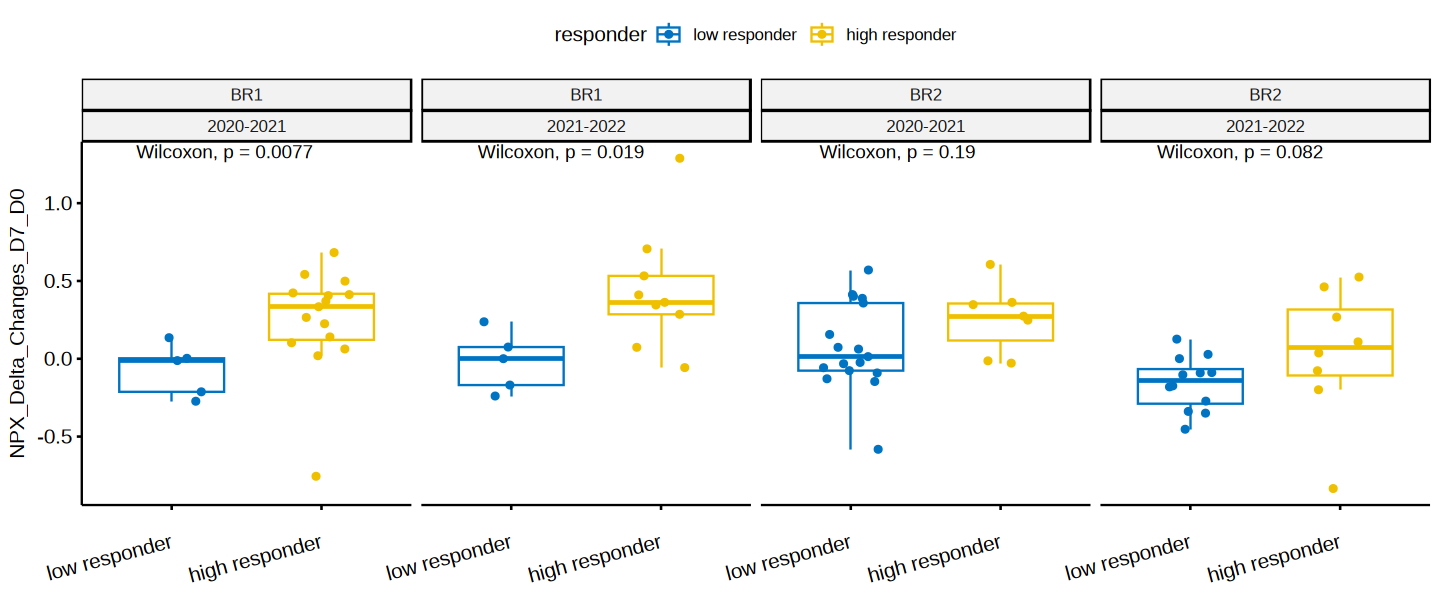

In [19]:
options(repr.plot.width = 12, repr.plot.height = 5)
grouped_data <- Olink_annotated %>%
  filter(
    responder %in% c("low responder", "high responder"),
    Flu_Year != "2019-2020",
    Visit_Type %in% c("FluYear"),
    !Flu_Day %in% c("Stand-Alone")
  ) %>%
  select(
    Assay, NPX_bridged, Flu_Year, subject.subjectGuid,
    Flu_Day, responder, cohort.cohortGuid
  ) %>%
  group_by(Assay, NPX_bridged, Flu_Year, subject.subjectGuid) %>%
  arrange(Flu_Day) %>%
  tidyr::pivot_wider(names_from = Flu_Day, values_from = NPX_bridged) %>%
  mutate(NPX_Delta_Changes_D7_D0 = Day_7 - Day_0)
ggboxplot(
    grouped_data %>%
        filter(Assay == "CD27") %>%
        ungroup() %>%
        mutate(cohort.cohortGuid = substr(subject.subjectGuid, 1, 3)),
    x = "responder", y = "NPX_Delta_Changes_D7_D0", color = "responder", palette = "jco",
    add = "jitter"
) + stat_compare_means() + facet_wrap(~ cohort.cohortGuid+Flu_Year , ncol = 4) + theme(axis.text.x = element_text(
    angle = 15, vjust = 0.5,
    hjust = 1
))+xlab("")


In [20]:
df_ressubset<-df_res %>% filter(p<0.05)

In [28]:
df_res_summary <- df_res %>%
    group_by(Assay, cohort.cohortGuid) %>%
    mutate(count = n()) %>%
    filter(count == 2 & prod(delta_diff) > 0) %>%
    summarise(combined_p = sumlog(p)$p, combined_delta_diff = mean(delta_diff))

`summarise()` has grouped output by 'Assay'. You can override using the
`.groups` argument.


In [29]:
sgnific<-df_res_summary %>% 
  summarise(sig_group1 = any(cohort.cohortGuid	 == "BR1" & combined_p < 0.05),
            sig_group2 = any(cohort.cohortGuid	 == "BR2" & combined_p < 0.05)) %>%
  mutate(overall = case_when(
    sig_group1 & sig_group2 ~ "both",
    sig_group1 ~ "signi in BR1",
    sig_group2 ~ "signi in BR2",
    TRUE ~ "non-signit in both"
  ))

In [30]:
df_res_summary<-df_res_summary%>%mutate(log10p= -log10(combined_p)) %>%  select(Assay,cohort.cohortGuid,log10p) %>% 
  tidyr::pivot_wider(names_from = cohort.cohortGuid, values_from = log10p) %>% left_join(sgnific %>% select(Assay,overall))

Joining with `by = join_by(Assay)`


Warning message:
“Removed 762 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 762 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 14 rows containing missing values (`geom_label_repel()`).”


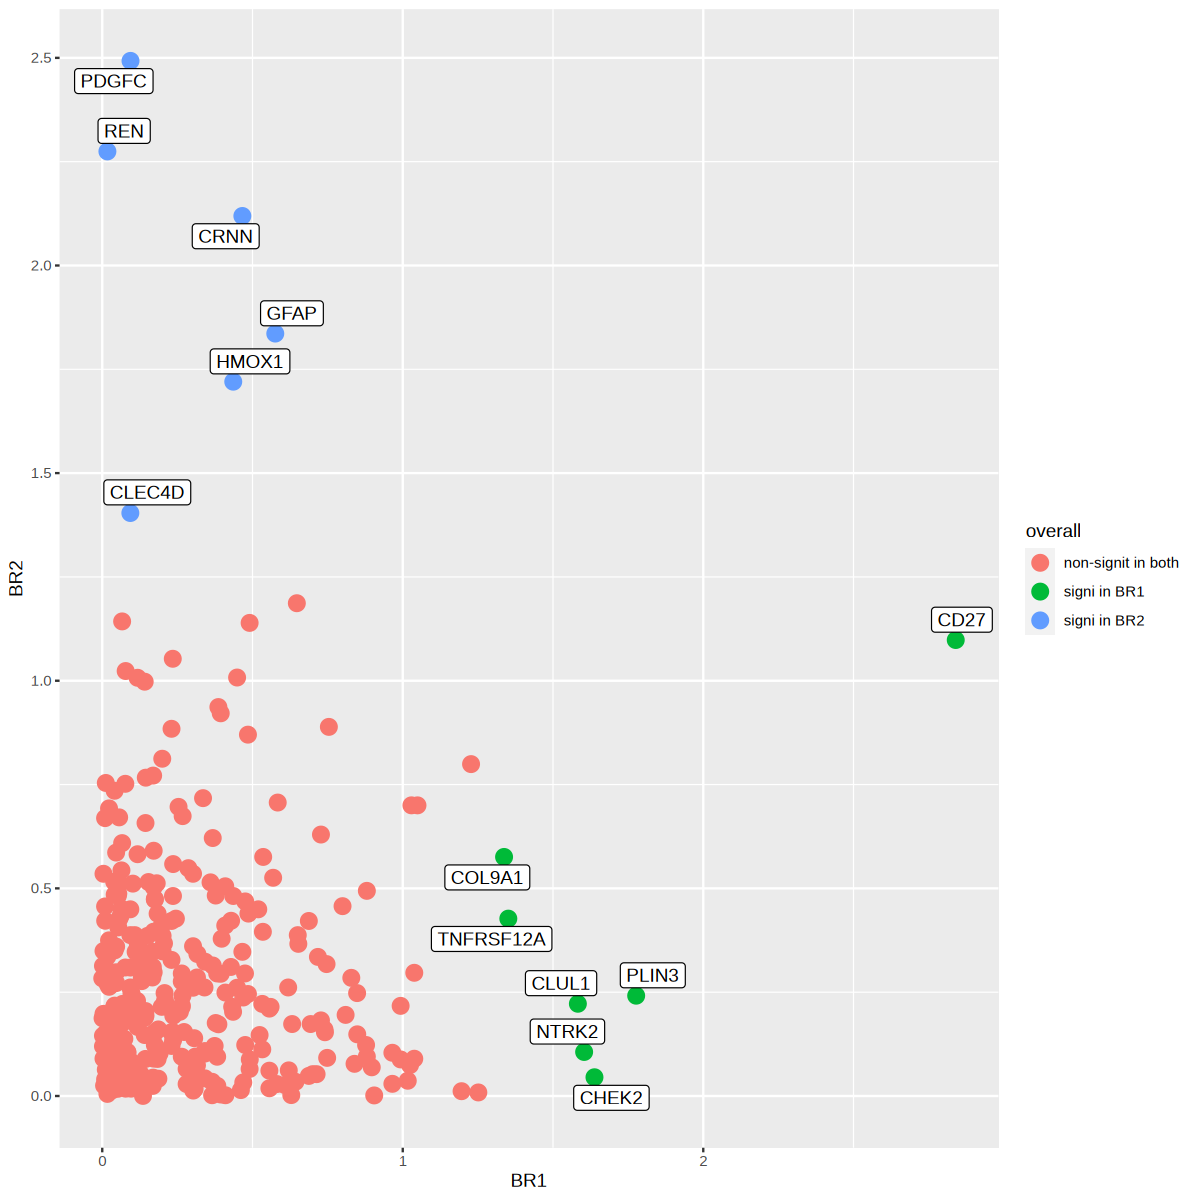

In [31]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(df_res_summary)  +
  aes(x=BR1, y=BR2, color=overall) + 
  geom_point() + 
  geom_point(size=4, data=df_res_summary) + 
  ggrepel::geom_label_repel(aes(label=Assay), color="black", 
             data=df_res_summary %>% filter(overall !="non-signit in both"))